In [1]:
import numpy as np
from tensorflow.keras.models import Model, Sequential
from keras.layers import (
    GlobalMaxPooling2D,
    Dense,
    Input,
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob as gb
import cv2
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.applications import resnet

In [2]:
shape = (150, 150, 3)
image_size = 150
path = "./Images/"

In [3]:
def read_images_from_directory(
    folder_path,
    desc,
):
    images = []
    labels = []

    for folder in os.listdir(folder_path):
        files = gb.glob(pathname=str(folder_path + "/" + folder + "/*.jpg"))

        for file in tqdm(files, desc=desc + " in " + folder):
            image = plt.imread(file)
            img_resized = cv2.resize(image, (image_size, image_size))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(folder)
    print(labels)
    return images, labels

In [4]:
x, y = read_images_from_directory(path, "Loading Data")

Loading Data in pituitary_tumor: 100%|██████████| 4504/4504 [00:30<00:00, 149.07it/s]

['glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma

In [5]:
x = np.array(x)

In [6]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
print(y)

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [7]:
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.25, random_state=42
)

In [8]:
print(len(x_train))  # 60%
print(len(x_val))  # 20%
print(len(x_test))  # 20%

11290
3764
3764


In [9]:
from keras.applications import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=shape)

In [10]:
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

In [14]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=earlystop,
)

Epoch 1/50
353/353 [==============================] - 59s 133ms/step - loss: 3.7060 - accuracy: 0.7387 - val_loss: 1.0157 - val_accuracy: 0.7641
Epoch 2/50
353/353 [==============================] - 41s 116ms/step - loss: 0.4402 - accuracy: 0.8704 - val_loss: 0.4229 - val_accuracy: 0.8672
Epoch 3/50
353/353 [==============================] - 41s 117ms/step - loss: 0.2404 - accuracy: 0.9176 - val_loss: 0.7245 - val_accuracy: 0.8026
Epoch 4/50
353/353 [==============================] - 40s 115ms/step - loss: 0.1912 - accuracy: 0.9321 - val_loss: 0.3890 - val_accuracy: 0.8836
Epoch 5/50
353/353 [==============================] - 41s 115ms/step - loss: 0.1153 - accuracy: 0.9582 - val_loss: 0.3812 - val_accuracy: 0.8874
Epoch 6/50
353/353 [==============================] - 41s 115ms/step - loss: 0.1275 - accuracy: 0.9585 - val_loss: 0.3331 - val_accuracy: 0.8993
Epoch 7/50
353/353 [==============================] - 41s 115ms/step - loss: 0.1172 - accuracy: 0.9592 - val_loss: 0.3824 - val_ac

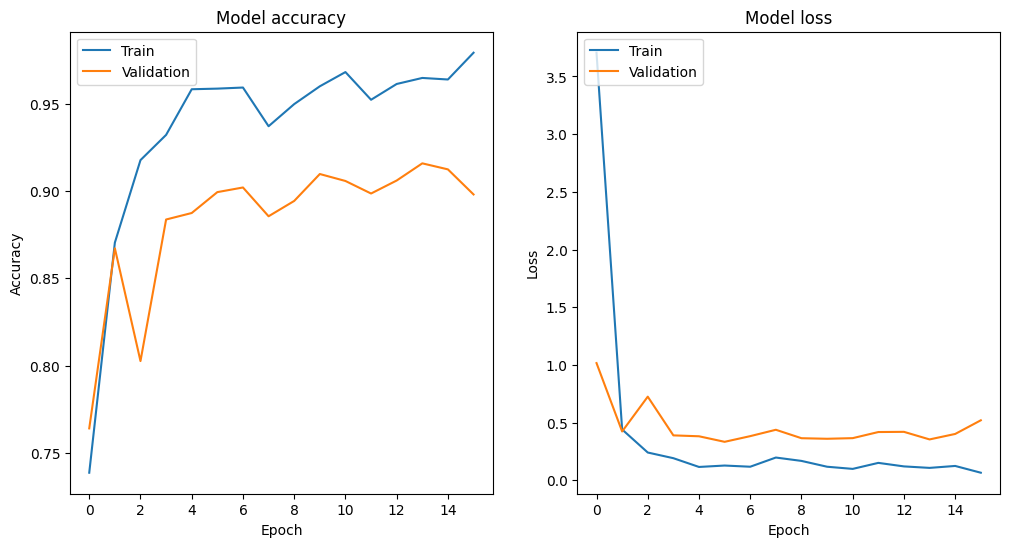

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

In [16]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

118/118 [==============================] - 11s 89ms/step - loss: 0.3173 - accuracy: 0.8996
Test accuracy: 0.8995749354362488
Test loss: 0.31731346249580383


In [17]:
# Make predictions on the test set
y_pred_probs = model.predict(x_test)

y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

118/118 [==============================] - 10s 87ms/step


In [18]:
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

In [19]:
print(f"Accuracy: {accuracy}")


print(f"Precision: {precision}")


print(f"Recall: {recall}")


print(f"F1 Score: {f1}")

Accuracy: 0.8995749202975558
Precision: 0.9030628840484637
Recall: 0.8995749202975558
F1 Score: 0.8997896174778445


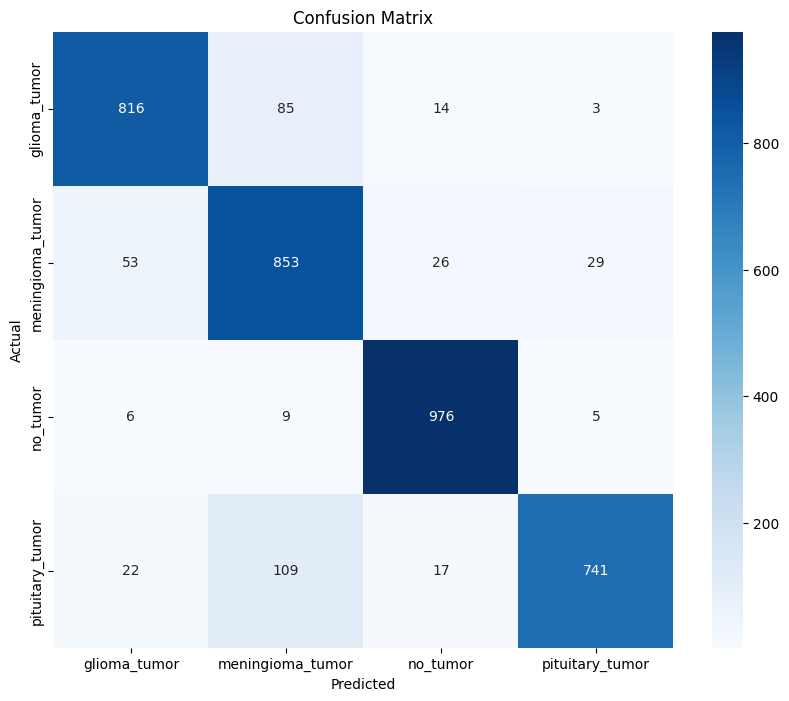

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "VGG16(150x150).h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\VGG16(150x150).h5
